##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 Tensorflow Lattice 实现形状约束


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/lattice/tutorials/shape_constraints"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看 </a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/shape_constraints.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/shape_constraints.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lattice/tutorials/shape_constraints.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png"> 下载笔记本</a></td>
</table>

## 概述

本教程概述了 TensorFlow Lattice (TFL) 库提供的约束和正则化器。我们将在合成数据集上使用 TFL Canned Estimator，但请注意，本教程中的所有内容也可以使用通过 TFL Keras 层构造的模型来完成。

在继续之前，请确保您的运行时已安装所有必需的软件包（如下方代码单元中导入的软件包）。

## 设置

安装 TF Lattice 软件包：

In [2]:
#@test {"skip": true}
!pip install tensorflow-lattice

  Using cached tensorflow_lattice-2.0.9-py2.py3-none-any.whl (235 kB)


  Using cached graphviz-0.17-py3-none-any.whl (18 kB)
  Using cached dm_sonnet-2.0.0-py3-none-any.whl (254 kB)


  Using cached dm_tree-0.1.6-cp37-cp37m-manylinux_2_24_x86_64.whl (93 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)


导入所需的软件包：

In [3]:
import tensorflow as tf

from IPython.core.pylabtools import figsize
import itertools
import logging
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

本指南中使用的默认值：

In [4]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE=0.01

## 餐厅评分的训练数据集

设想一个简化的场景，我们要确定用户是否会点击餐厅搜索结果。任务是基于给定的输入特征预测点击率 (CTR)：

- 平均评分 (`avg_rating`)：一个数字特征，值在 [1,5] 区间内。
- 评论数 (`num_reviews`)：一个数字特征，上限值为 200，我们使用该值作为衡量餐厅热度的指标。
- 美元评分 (`dollar_rating`)：一个分类特征，其字符串值位于集合 {"D", "DD", "DDD", "DDDD"} 内。

我们创建一个合成数据集，其真实 CTR 值由以下公式得出：$$ CTR = 1 / (1 + exp{\mbox{b(dollar_rating)}-\mbox{avg_rating}\times log(\mbox{num_reviews}) /4 }) $$，其中 $b(\cdot)$ 可将每个 `dollar_rating` 转换为基准值：$$ \mbox{D}\to 3，\ \mbox{DD}\to 2，\ \mbox{DDD}\to 4，\ \mbox{DDDD}\to 4.5。$$

此公式反映了典型的用户模式。例如，在所有其他条件固定的情况下，用户更喜欢星级较高的餐厅，"$$" 餐厅的点击数高于 "$" 餐厅，低于 "$$$" 和 "$$$$" 餐厅。 

In [5]:
def click_through_rate(avg_ratings, num_reviews, dollar_ratings):
  dollar_rating_baseline = {"D": 3, "DD": 2, "DDD": 4, "DDDD": 4.5}
  return 1 / (1 + np.exp(
      np.array([dollar_rating_baseline[d] for d in dollar_ratings]) -
      avg_ratings * np.log1p(num_reviews) / 4))

让我们看一下此 CTR 函数的等高线图。

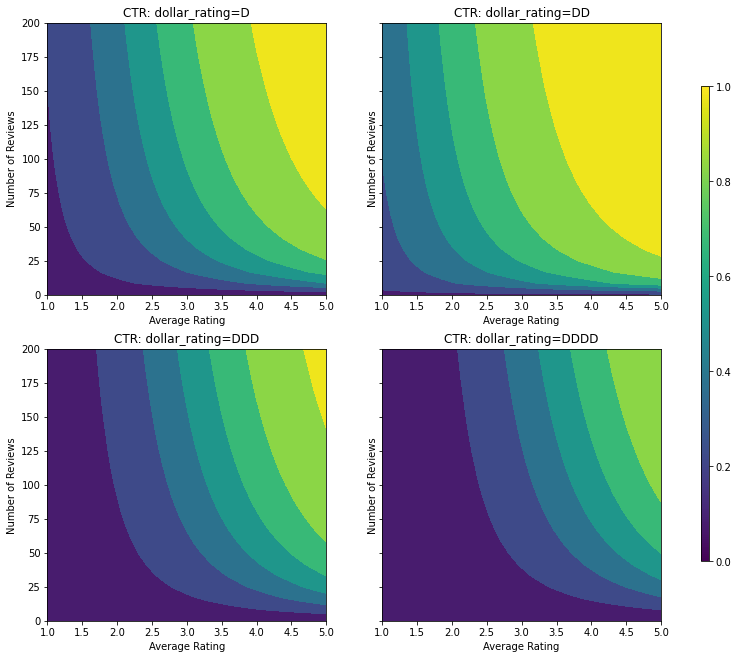

In [6]:
def color_bar():
  bar = matplotlib.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(0, 1, True),
      cmap="viridis",
  )
  bar.set_array([0, 1])
  return bar


def plot_fns(fns, split_by_dollar=False, res=25):
  """Generates contour plots for a list of (name, fn) functions."""
  num_reviews, avg_ratings = np.meshgrid(
      np.linspace(0, 200, num=res),
      np.linspace(1, 5, num=res),
  )
  if split_by_dollar:
    dollar_rating_splits = ["D", "DD", "DDD", "DDDD"]
  else:
    dollar_rating_splits = [None]
  if len(fns) == 1:
    fig, axes = plt.subplots(2, 2, sharey=True, tight_layout=False)
  else:
    fig, axes = plt.subplots(
        len(dollar_rating_splits), len(fns), sharey=True, tight_layout=False)
  axes = axes.flatten()
  axes_index = 0
  for dollar_rating_split in dollar_rating_splits:
    for title, fn in fns:
      if dollar_rating_split is not None:
        dollar_ratings = np.repeat(dollar_rating_split, res**2)
        values = fn(avg_ratings.flatten(), num_reviews.flatten(),
                    dollar_ratings)
        title = "{}: dollar_rating={}".format(title, dollar_rating_split)
      else:
        values = fn(avg_ratings.flatten(), num_reviews.flatten())
      subplot = axes[axes_index]
      axes_index += 1
      subplot.contourf(
          avg_ratings,
          num_reviews,
          np.reshape(values, (res, res)),
          vmin=0,
          vmax=1)
      subplot.title.set_text(title)
      subplot.set(xlabel="Average Rating")
      subplot.set(ylabel="Number of Reviews")
      subplot.set(xlim=(1, 5))

  _ = fig.colorbar(color_bar(), cax=fig.add_axes([0.95, 0.2, 0.01, 0.6]))


figsize(11, 11)
plot_fns([("CTR", click_through_rate)], split_by_dollar=True)

### 准备数据


现在，我们需要创建合成数据集。我们首先生成餐厅及其特征的模拟数据集。

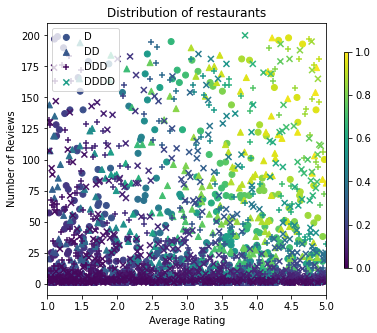

In [7]:
def sample_restaurants(n):
  avg_ratings = np.random.uniform(1.0, 5.0, n)
  num_reviews = np.round(np.exp(np.random.uniform(0.0, np.log(200), n)))
  dollar_ratings = np.random.choice(["D", "DD", "DDD", "DDDD"], n)
  ctr_labels = click_through_rate(avg_ratings, num_reviews, dollar_ratings)
  return avg_ratings, num_reviews, dollar_ratings, ctr_labels


np.random.seed(42)
avg_ratings, num_reviews, dollar_ratings, ctr_labels = sample_restaurants(2000)

figsize(5, 5)
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=False)
for rating, marker in [("D", "o"), ("DD", "^"), ("DDD", "+"), ("DDDD", "x")]:
  plt.scatter(
      x=avg_ratings[np.where(dollar_ratings == rating)],
      y=num_reviews[np.where(dollar_ratings == rating)],
      c=ctr_labels[np.where(dollar_ratings == rating)],
      vmin=0,
      vmax=1,
      marker=marker,
      label=rating)
plt.xlabel("Average Rating")
plt.ylabel("Number of Reviews")
plt.legend()
plt.xlim((1, 5))
plt.title("Distribution of restaurants")
_ = fig.colorbar(color_bar(), cax=fig.add_axes([0.95, 0.2, 0.01, 0.6]))

我们来生成训练、验证和测试数据集。当用户查看搜索结果中的餐厅时，我们可以记录用户的参与（点击或不点击）作为样本点。

实际上，用户通常不会浏览所有搜索结果。这意味着用户可能只会看到被当前所用排名模型评为“好”的餐厅。这样一来，在训练数据集中，“好”餐厅将获得更频繁的关注并存在过度表示的情况。使用更多特征时，训练数据集在特征空间的“差”部分可能会存在较大空缺。

使用该模型进行评分时，通常会基于分布更均衡的所有相关结果进行评估，而训练数据集并不能很好地提供这种分布。在这种情况下，灵活且复杂的模型可能会因过拟合存在过度表达情况的数据点而缺乏泛化能力。我们通过运用领域知识来添加*形状约束*，在模型无法从训练数据集获取充分信息的情况下引导模型做出合理的预测，从而解决这一问题。

在本例中，训练数据集主要由用户与热门餐厅的交互组成。测试数据集采用均衡的分布来模拟上述评估环境。请注意，此类测试数据集在实际问题环境中将不可用。

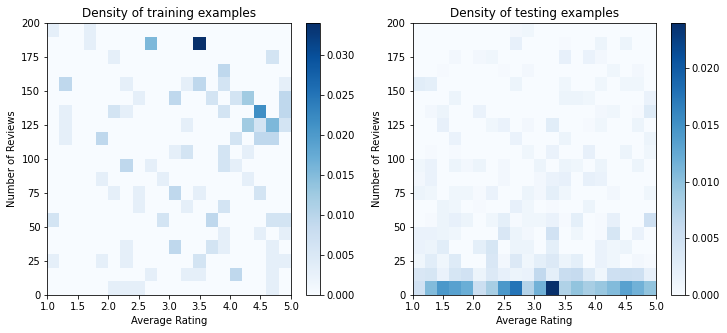

In [8]:
def sample_dataset(n, testing_set):
  (avg_ratings, num_reviews, dollar_ratings, ctr_labels) = sample_restaurants(n)
  if testing_set:
    # Testing has a more uniform distribution over all restaurants.
    num_views = np.random.poisson(lam=3, size=n)
  else:
    # Training/validation datasets have more views on popular restaurants.
    num_views = np.random.poisson(lam=ctr_labels * num_reviews / 50.0, size=n)

  return pd.DataFrame({
      "avg_rating": np.repeat(avg_ratings, num_views),
      "num_reviews": np.repeat(num_reviews, num_views),
      "dollar_rating": np.repeat(dollar_ratings, num_views),
      "clicked": np.random.binomial(n=1, p=np.repeat(ctr_labels, num_views))
  })


# Generate datasets.
np.random.seed(42)
data_train = sample_dataset(500, testing_set=False)
data_val = sample_dataset(500, testing_set=False)
data_test = sample_dataset(500, testing_set=True)

# Plotting dataset densities.
figsize(12, 5)
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=False)
for ax, data, title in [(axs[0], data_train, "training"),
                        (axs[1], data_test, "testing")]:
  _, _, _, density = ax.hist2d(
      x=data["avg_rating"],
      y=data["num_reviews"],
      bins=(np.linspace(1, 5, num=21), np.linspace(0, 200, num=21)),
      density=True,
      cmap="Blues",
  )
  ax.set(xlim=(1, 5))
  ax.set(ylim=(0, 200))
  ax.set(xlabel="Average Rating")
  ax.set(ylabel="Number of Reviews")
  ax.title.set_text("Density of {} examples".format(title))
  _ = fig.colorbar(density, ax=ax)

定义用于训练和评估的 input_fn：

In [9]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_train,
    y=data_train["clicked"],
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    shuffle=False,
)

# feature_analysis_input_fn is used for TF Lattice estimators.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_train,
    y=data_train["clicked"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

val_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_val,
    y=data_val["clicked"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_test,
    y=data_test["clicked"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

## 拟合梯度提升树

让我们从两个函数开始：`avg_rating` 和 `num_reviews`。

我们创建一些辅助函数，用于绘制和计算验证与测试指标。

In [10]:
def analyze_two_d_estimator(estimator, name):
  # Extract validation metrics.
  metric = estimator.evaluate(input_fn=val_input_fn)
  print("Validation AUC: {}".format(metric["auc"]))
  metric = estimator.evaluate(input_fn=test_input_fn)
  print("Testing AUC: {}".format(metric["auc"]))

  def two_d_pred(avg_ratings, num_reviews):
    results = estimator.predict(
        tf.compat.v1.estimator.inputs.pandas_input_fn(
            x=pd.DataFrame({
                "avg_rating": avg_ratings,
                "num_reviews": num_reviews,
            }),
            shuffle=False,
        ))
    return [x["logistic"][0] for x in results]

  def two_d_click_through_rate(avg_ratings, num_reviews):
    return np.mean([
        click_through_rate(avg_ratings, num_reviews,
                           np.repeat(d, len(avg_ratings)))
        for d in ["D", "DD", "DDD", "DDDD"]
    ],
                   axis=0)

  figsize(11, 5)
  plot_fns([("{} Estimated CTR".format(name), two_d_pred),
            ("CTR", two_d_click_through_rate)],
           split_by_dollar=False)


我们可以基于数据集拟合 TensorFlow 梯度提升决策树：

Validation AUC: 0.6333084106445312


Testing AUC: 0.7746500372886658


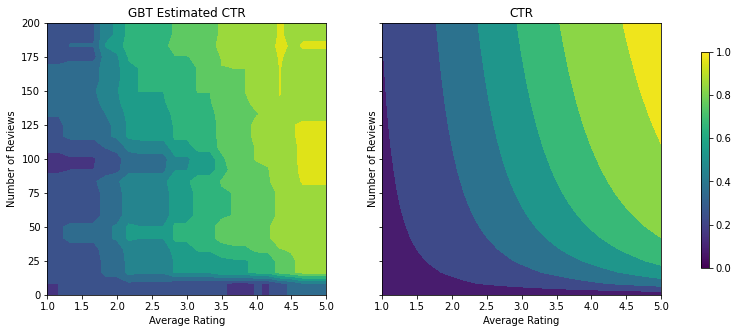

In [11]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
gbt_estimator = tf.estimator.BoostedTreesClassifier(
    feature_columns=feature_columns,
    # Hyper-params optimized on validation set.
    n_batches_per_layer=1,
    max_depth=2,
    n_trees=50,
    learning_rate=0.05,
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
gbt_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(gbt_estimator, "GBT")

即使该模型已捕获到真实 CTR 的总体形状并具有不错的验证指标，但它在输入空间的多个部分上都呈现出违背直觉的行为：估算的 CTR 随着平均评分或评论数量的增加而降低。这是由于训练数据集无法充分覆盖到的区域缺少样本点。该模型根本无法仅基于数据推断出正确的行为。

为了解决这个问题，我们强制应用了形状约束，使模型必须输出相对于平均评分和评论数量单调递增的值。稍后我们将展示如何在 TFL 中实现这一方案。


## 拟合 DNN

我们可以对 DNN 分类器重复相同的步骤。我们可以观察到类似的模式：样本点不够和评论数量过低就无法进行有效的推断。请注意，尽管验证指标优于梯度提升树解决方案，但测试指标却要差得多。

Validation AUC: 0.6532860398292542


Testing AUC: 0.746737539768219


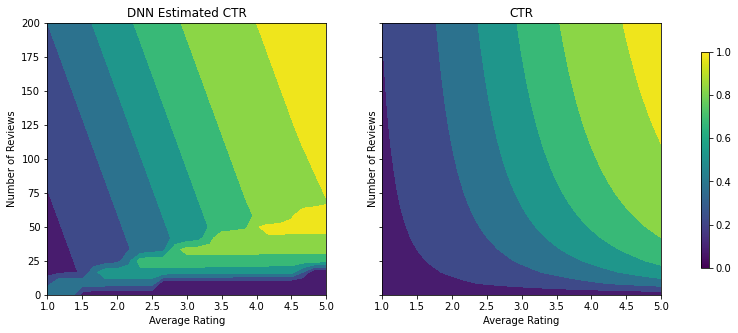

In [12]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
dnn_estimator = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    # Hyper-params optimized on validation set.
    hidden_units=[16, 8, 8],
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
dnn_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(dnn_estimator, "DNN")

## 形状约束

TensorFlow Lattice (TFL) 侧重于强制应用形状约束，以保护超出训练数据的模型行为。这些形状约束应用于 TFL Keras 层。相关详细信息可参见[我们的 JMLR 论文](http://jmlr.org/papers/volume17/15-243/15-243.pdf)。

在本教程中，我们使用 TF Canned Estimator 覆盖各种形状约束，但是请注意，所有这些步骤都可以使用通过 TFL Keras 层创建的模型来完成。

与任何其他 TensorFlow Estimator 一样，TFL Canned Estimator 使用[特征列](https://tensorflow.google.cn/api_docs/python/tf/feature_column)定义输入格式，并使用训练 input_fn 传入数据。使用 TFL Canned Estimator 还需要：

- *模型配置*：定义模型架构以及按特征的形状约束和正则化器。
- *特征分析 input_fn*：传递数据以供 TFL 初始化的 TF input_fn。

有关更详尽的介绍，请参阅 Canned Estimator 教程或 API 文档。

### 单调性

我们首先通过向两个特征添加单调性形状约束来解决单调性问题。

为了命令 TFL 强制应用形状约束，我们在*特征配置*中指定约束。以下代码展示了如何通过设置 `monotonicity="increasing"` 来要求输出相对于 `num_reviews` 和 `avg_rating` 单调递增。


Validation AUC: 0.6553398370742798


Testing AUC: 0.7784496545791626


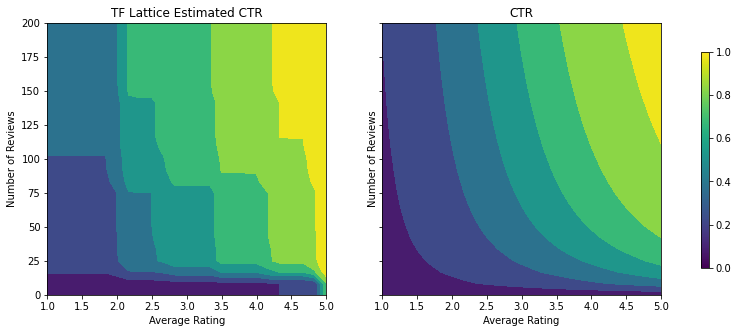

In [13]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(tfl_estimator, "TF Lattice")

使用 `CalibratedLatticeConfig` 可以创建一个封装分类器，先对每个输入（数字特征的分段线性函数）应用*校准器*，然后应用*点阵*层以非线性方式融合校准的特征。我们可以使用 `tfl.visualization` 可视化模型。特别是，下图展示了封装分类器中所含的两个已训练校准器。


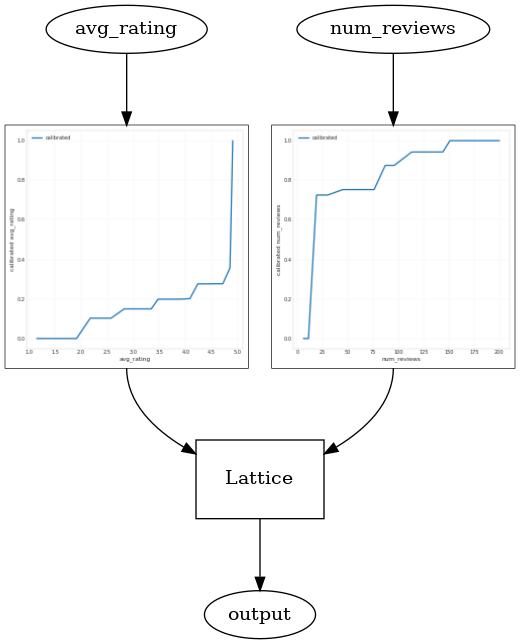

In [14]:
def save_and_visualize_lattice(tfl_estimator):
  saved_model_path = tfl_estimator.export_saved_model(
      "/tmp/TensorFlow_Lattice_101/",
      tf.estimator.export.build_parsing_serving_input_receiver_fn(
          feature_spec=tf.feature_column.make_parse_example_spec(
              feature_columns)))
  model_graph = tfl.estimators.get_model_graph(saved_model_path)
  figsize(8, 8)
  tfl.visualization.draw_model_graph(model_graph)
  return model_graph

_ = save_and_visualize_lattice(tfl_estimator)

添加约束后，估算的 CTR 将始终随着平均评分的提高或评论数量的增加而提高。这是通过确保校准器和点阵的单调性来实现的。

### 收益递减

[收益递减](https://en.wikipedia.org/wiki/Diminishing_returns)意味着增大某个特征值的边际收益将随着该值的递大而降低。在我们的案例中，我们希望 `num_reviews` 特征遵循此模式，因此我们可以相应地配置其校准器。请注意，我们可以将收益递减分解为两个充分条件：

- 校准器单调递增，并且
- 校准器为凹函数。


Validation AUC: 0.6403099298477173


Testing AUC: 0.7891009449958801


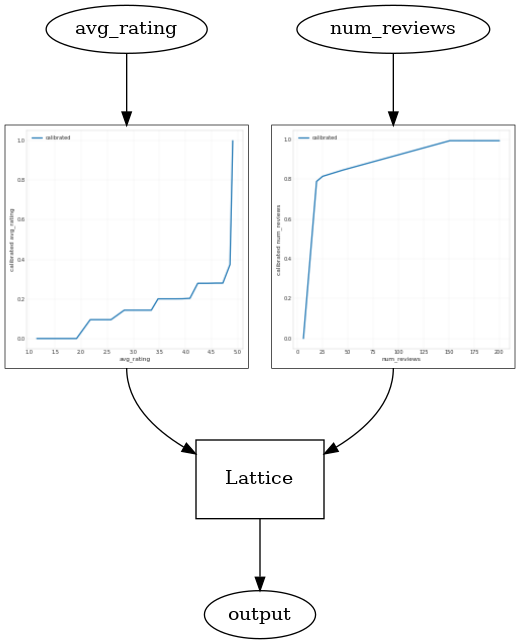

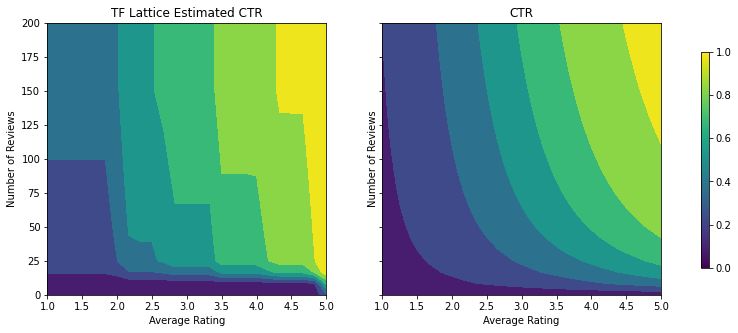

In [15]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=20,
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(tfl_estimator, "TF Lattice")
_ = save_and_visualize_lattice(tfl_estimator)

请注意添加凹函数约束将如何提升测试指标。预测图也可以更好地还原基本事实。

### 二维形状约束：信任

如果一家餐厅被评为 5 星级餐厅，但只有一两条评论，那么这个评分可能并不可靠（这家餐厅实际上可能不怎么样）；而有数百条评论的餐厅被评为 4 星级餐厅，那么这个评分的可靠性就高得多（在这种情况下，这家餐厅可能不错）。可以看到，餐厅的评论数量会影响我们对餐厅平均评分的信任度。

我们可以使用 TFL 信任约束来告知模型，一个特征值越大（或越小）表示另一个特征的可靠或可信度越高。在特征配置中设置 `reflects_trust_in` 配置即可实现这一目标。

Validation AUC: 0.6407766938209534


Testing AUC: 0.7891259789466858


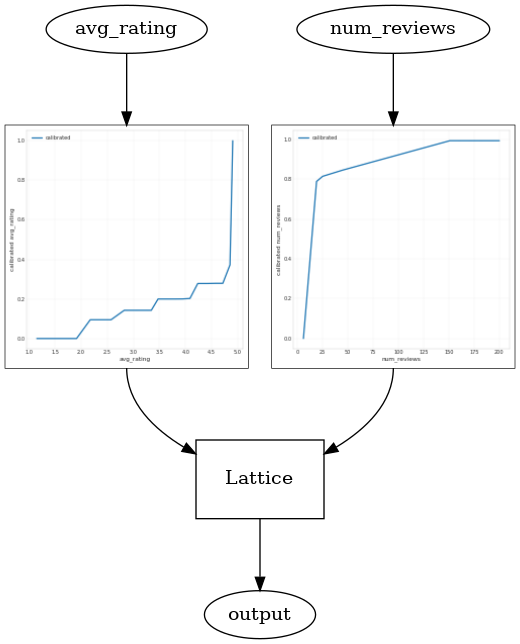

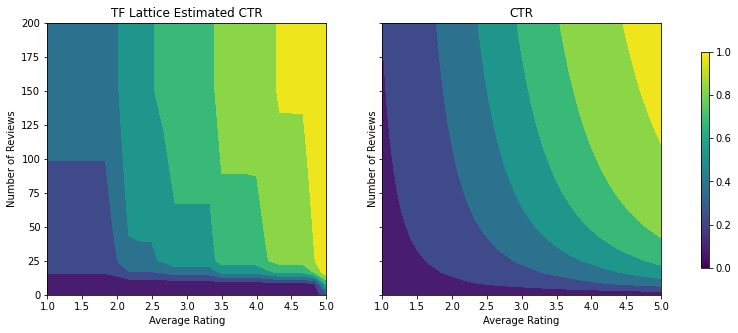

In [16]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=20,
            # Larger num_reviews indicating more trust in avg_rating.
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(tfl_estimator, "TF Lattice")
model_graph = save_and_visualize_lattice(tfl_estimator)

下图展示了已训练的点阵函数。基于信任约束的强制性限制，我们期望校准的 `num_reviews` 值越大，相对于校准的 `avg_rating` 的斜率就越高，进而使点阵输出的跨度更大。

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_lattice/python/visualization.py:575: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes = figure.gca(projection='3d')


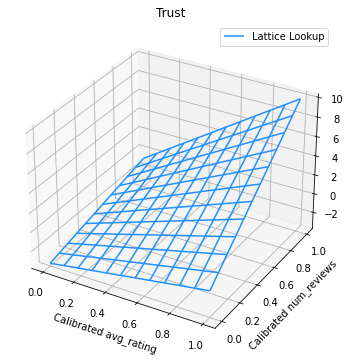

In [17]:
lat_mesh_n = 12
lat_mesh_x, lat_mesh_y = tfl.test_utils.two_dim_mesh_grid(
    lat_mesh_n**2, 0, 0, 1, 1)
lat_mesh_fn = tfl.test_utils.get_hypercube_interpolation_fn(
    model_graph.output_node.weights.flatten())
lat_mesh_z = [
    lat_mesh_fn([lat_mesh_x.flatten()[i],
                 lat_mesh_y.flatten()[i]]) for i in range(lat_mesh_n**2)
]
trust_plt = tfl.visualization.plot_outputs(
    (lat_mesh_x, lat_mesh_y),
    {"Lattice Lookup": lat_mesh_z},
    figsize=(6, 6),
)
trust_plt.title("Trust")
trust_plt.xlabel("Calibrated avg_rating")
trust_plt.ylabel("Calibrated num_reviews")
trust_plt.show()

### 平滑校准器

现在我们来看一下 `avg_rating` 的校准器。尽管单调递增，但其斜率的变化却唐突且难以解释。这表明我们可能要考虑使用 `regularizer_configs` 中的正则化器设置平滑此校准器。

在此，我们应用了 `wrinkle` 正则化器来减少曲率的变化。您也可以使用 `laplacian` 正则化器展平校准器，以及使用 `hessian` 正则化器使其更加线性。


Validation AUC: 0.6465646028518677


Testing AUC: 0.7948338389396667


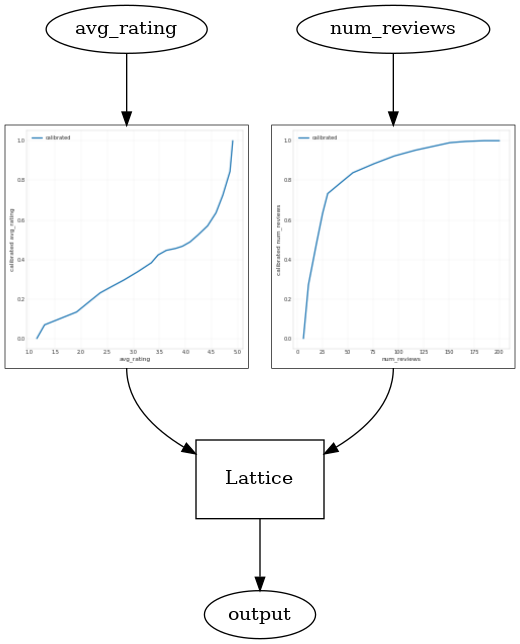

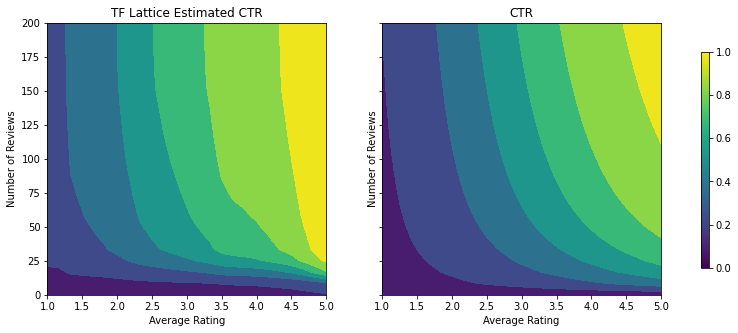

In [18]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=20,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
            ],
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
            ],
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_two_d_estimator(tfl_estimator, "TF Lattice")
_ = save_and_visualize_lattice(tfl_estimator)

校准器现已变得平滑，总体估算的 CTR 可更准确地符合实际情况。这在测试指标和等高线图中均有体现。

### 分类校准的部分单调性

到目前为止，我们一直是仅在模型中使用两个数字特征。在此，我们将使用分类校准层添加第三个特征。我们还是从设置用于绘图和指标计算的辅助函数开始。

In [19]:
def analyze_three_d_estimator(estimator, name):
  # Extract validation metrics.
  metric = estimator.evaluate(input_fn=val_input_fn)
  print("Validation AUC: {}".format(metric["auc"]))
  metric = estimator.evaluate(input_fn=test_input_fn)
  print("Testing AUC: {}".format(metric["auc"]))

  def three_d_pred(avg_ratings, num_reviews, dollar_rating):
    results = estimator.predict(
        tf.compat.v1.estimator.inputs.pandas_input_fn(
            x=pd.DataFrame({
                "avg_rating": avg_ratings,
                "num_reviews": num_reviews,
                "dollar_rating": dollar_rating,
            }),
            shuffle=False,
        ))
    return [x["logistic"][0] for x in results]

  figsize(11, 22)
  plot_fns([("{} Estimated CTR".format(name), three_d_pred),
            ("CTR", click_through_rate)],
           split_by_dollar=True)
  

要包含第三个特征 `dollar_rating`，请回想一下，分类特征在 TFL 中需要稍作不同处理，无论是作为特征列还是作为特征配置。在此，我们强制应用部分单调性约束，即在所有其他输入均固定不变的情况下，“DD”餐厅的输出应大于“D”餐厅的输出。这是使用特征配置中的 `monotonicity` 设置完成的。

Validation AUC: 0.7714711427688599


Testing AUC: 0.8594028949737549


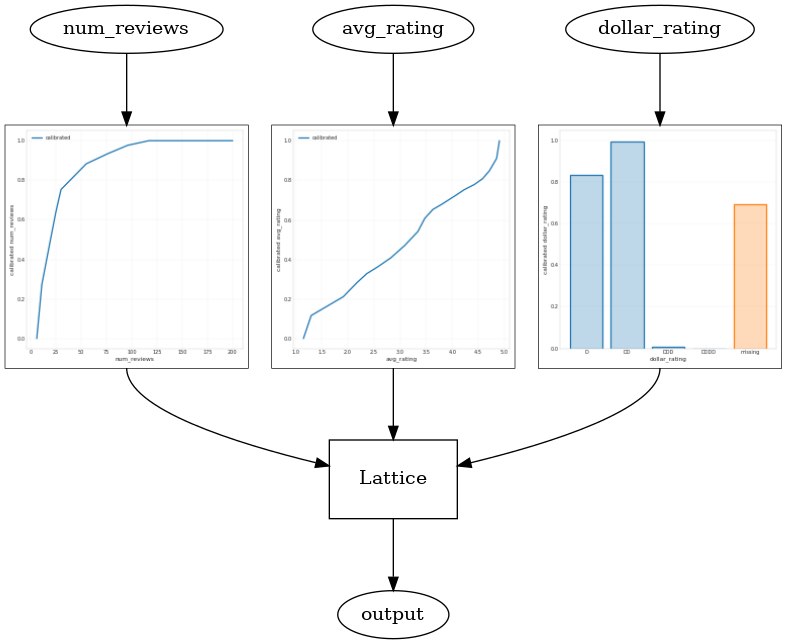

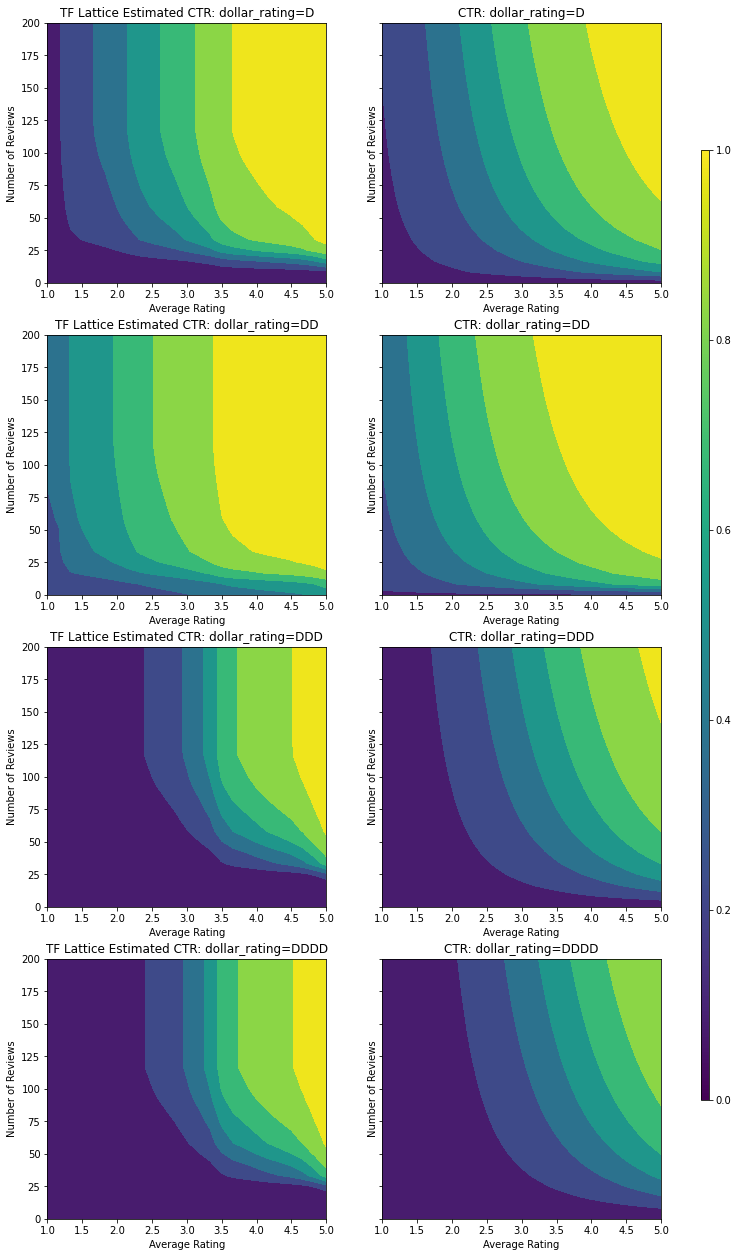

In [20]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
    tf.feature_column.categorical_column_with_vocabulary_list(
        "dollar_rating",
        vocabulary_list=["D", "DD", "DDD", "DDDD"],
        dtype=tf.string,
        default_value=0),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=20,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
            ],
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=20,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="dollar_rating",
            lattice_size=2,
            pwl_calibration_num_keypoints=4,
            # Here we only specify one monotonicity:
            # `D` resturants has smaller value than `DD` restaurants
            monotonicity=[("D", "DD")],
        ),
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_three_d_estimator(tfl_estimator, "TF Lattice")
_ = save_and_visualize_lattice(tfl_estimator)

此分类校准器展示了模型输出的优先级：DD &gt; D &gt; DDD &gt; DDDD，这与我们的设置一致。请注意，还有一列用于缺失值。尽管我们的训练和测试数据中没有缺失特征，但当下游模型使用期间出现值缺失的情况时，该模型可提供对缺失值的推算。

在此，我们还将绘制以 `dollar_rating` 为条件的此模型的预测 CTR。请注意，我们需要的所有约束在每个切片内都要得到满足。

### 输出校准

对于到目前为止我们训练的所有 TFL 模型，点阵层（在模型图中示为“Lattice”）均直接输出模型预测。有时，我们不确定是否应对点阵输出进行重新调整以激发模型输出：

- 特征为 $log$ 计数，而标签为计数。
- 点阵被配置为仅包含少量顶点，但标签分布却相对复杂。

在这些情况下，我们可以在点阵输出和模型输出之间添加另一个校准器，以提高模型的灵活性。在此，我们向刚刚构建的模型添加一个带有 5 个关键点的校准器层。我们还会为输出校准器添加一个正则化器，使函数保持平滑。


Validation AUC: 0.769044041633606


Testing AUC: 0.861021876335144


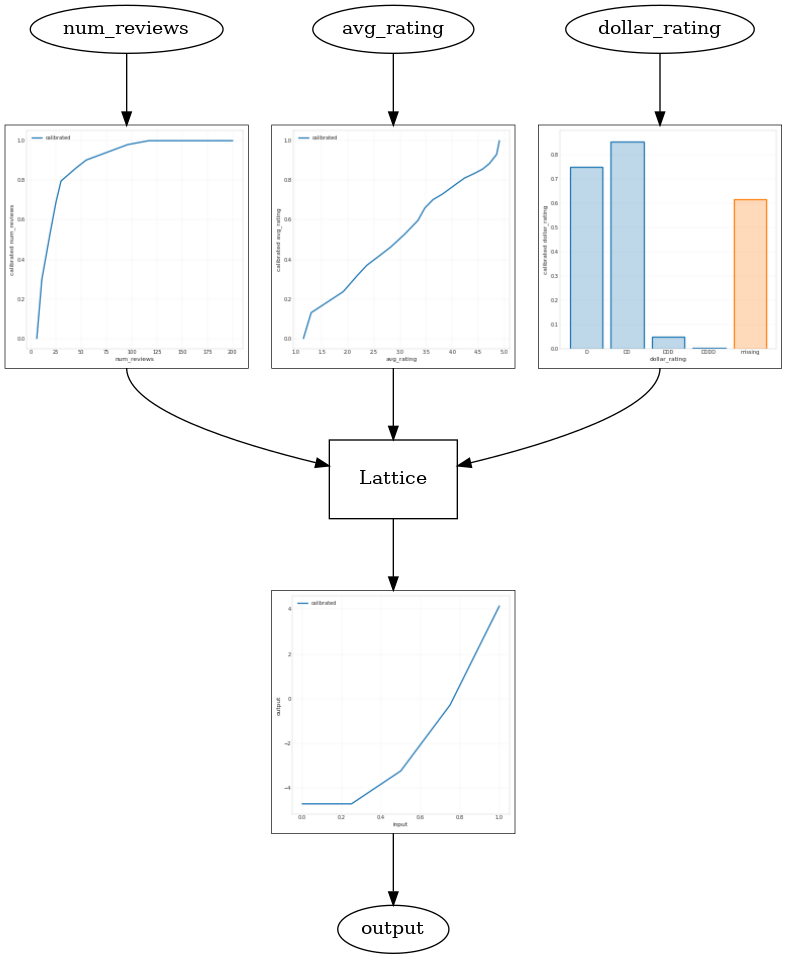

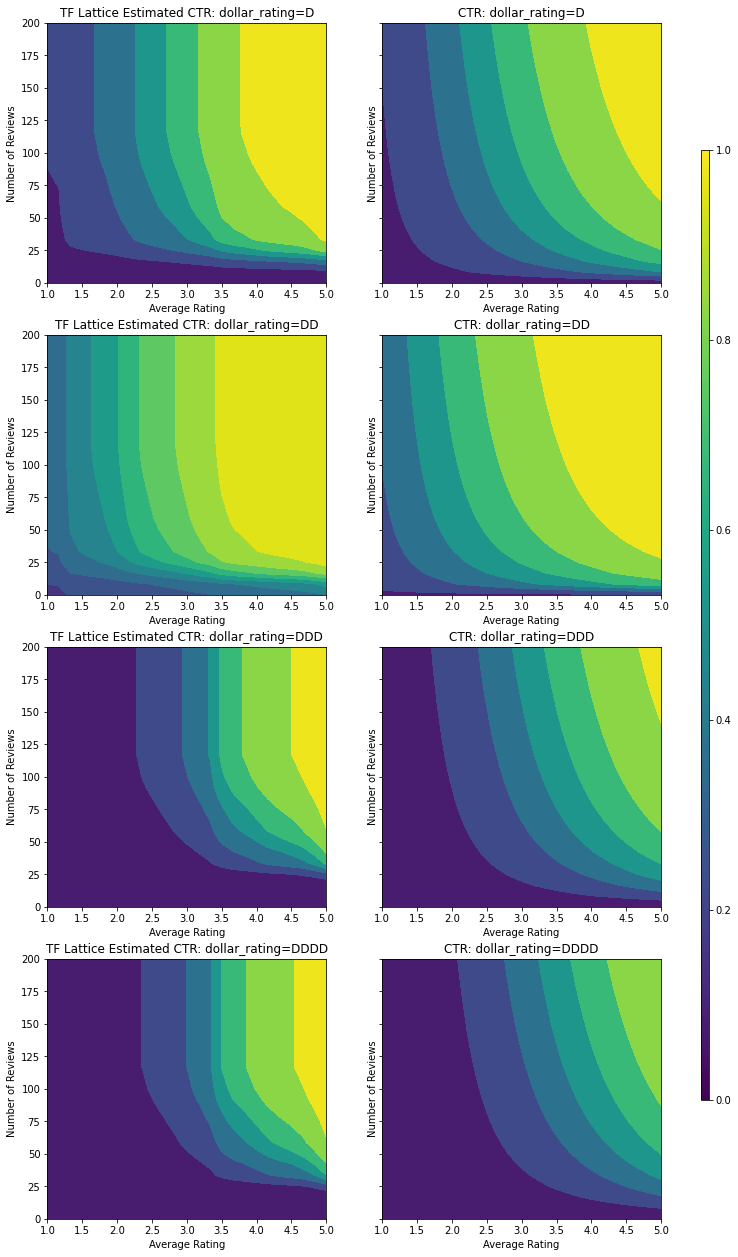

In [21]:
feature_columns = [
    tf.feature_column.numeric_column("num_reviews"),
    tf.feature_column.numeric_column("avg_rating"),
    tf.feature_column.categorical_column_with_vocabulary_list(
        "dollar_rating",
        vocabulary_list=["D", "DD", "DDD", "DDDD"],
        dtype=tf.string,
        default_value=0),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    output_calibration=True,
    output_calibration_num_keypoints=5,
    regularizer_configs=[
        tfl.configs.RegularizerConfig(name="output_calib_wrinkle", l2=0.1),
    ],
    feature_configs=[
    tfl.configs.FeatureConfig(
        name="num_reviews",
        lattice_size=2,
        monotonicity="increasing",
        pwl_calibration_convexity="concave",
        pwl_calibration_num_keypoints=20,
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
        ],
        reflects_trust_in=[
            tfl.configs.TrustConfig(
                feature_name="avg_rating", trust_type="edgeworth"),
        ],
    ),
    tfl.configs.FeatureConfig(
        name="avg_rating",
        lattice_size=2,
        monotonicity="increasing",
        pwl_calibration_num_keypoints=20,
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name="calib_wrinkle", l2=1.0),
        ],
    ),
    tfl.configs.FeatureConfig(
        name="dollar_rating",
        lattice_size=2,
        pwl_calibration_num_keypoints=4,
        # Here we only specify one monotonicity:
        # `D` resturants has smaller value than `DD` restaurants
        monotonicity=[("D", "DD")],
    ),
])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)
analyze_three_d_estimator(tfl_estimator, "TF Lattice")
_ = save_and_visualize_lattice(tfl_estimator)

最终的测试指标和统计图展示了使用常识约束如何帮助模型避免意外行为并针对整个输入空间实现更好的推断。